# Vignette Notebook walking through how to load and use the full 1240K .hdf5 File

In [1]:
### Do some standard imports (Welcome to the Python world...)
import numpy as np    # Great libary to do array calculations in C speed
import pandas as pd   # Great database library, very R like
import matplotlib.pyplot as plt # Powerful plotting library there is
import os as os
import multiprocessing as mp
import h5py    # The hdf5 Libarary
import allel

### Set working Folder correctly
path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


# Step 1: Load h5 into Memory
The hdf5 here is based on Ali's imputed Genotype data and supplied with some extra data (recombination map).  
It contains meta information for every 1240K SNPs (e.g. ref, alt allele, position, map position) as well as genotype information unimputed (e.g. read counts) as well as imputed (e.g. diploid genotype calls, genotype likelihoods)

In [4]:
%%time
path_h5="./data/hdf5/1240k_v43/all_ch.h5"
f = h5py.File(path_h5, "r")

CPU times: user 467 µs, sys: 0 ns, total: 467 µs
Wall time: 635 µs


### That's it! The object is linked now - it took ~1ms!
Let's see what it can do! HDF5 is organized like a folder,  
into which the data (linearized arrays of matrices, containing booleans, integers or strings) are packed.

In [5]:
list(f)  # Gives all the top level directories

['calldata', 'samples', 'variants']

### Let's see what's in these directories!
- sample is already data
- callddata and variants are directories

In [7]:
list(f["calldata"])

['AD', 'DS', 'GP', 'GT', 'HS', 'PL']

In [8]:
list(f["variants"])

['AF',
 'ALT',
 'BUF',
 'CHROM',
 'FILTER_PASS',
 'ID',
 'INFO',
 'POS',
 'QUAL',
 'RAF',
 'REF',
 'altlen',
 'is_snp',
 'numalt']

### Well that's like VCF. Surprise surprise, because this hdf5 is created from a vcf!
Key fields of calldata: 
- AD, allele depth
- PL, genotype probabilities in phred scale (before imputation)
- GT diploid genotypes (imputed)
- GP genotype probabilities imputed (normal scale)

### Let's check out some of these fields

In [9]:
%%time
np.shape(f["calldata/AD"])

CPU times: user 822 µs, sys: 0 ns, total: 822 µs
Wall time: 1.03 ms


(1100313, 14523, 4)

### Wow 1100313 variants, and 14523 Individuals! Let's load some data.
The variants are the ones that match 1000G ref and alt allle, the rest has been filtered.

In [50]:
f["calldata/AD"][:5,60,:2] # The two is there because it's only biallic SNPs

array([[ 0,  2],
       [ 2,  0],
       [-1, -1],
       [ 0,  2],
       [ 1,  1]], dtype=int16)

In [10]:
%%time
ad = f["calldata/AD"]

CPU times: user 272 µs, sys: 73 µs, total: 345 µs
Wall time: 358 µs


Wait, that was suspiciously quick? What's up?

In [13]:
ad

<HDF5 dataset "AD": shape (1100313, 14523, 4), type "<i2">

### Oh it's only the object, not what's in there
let's load individuals i=100.

In [14]:
%%time
x = ad[:,100,:2]

CPU times: user 978 ms, sys: 119 ms, total: 1.1 s
Wall time: 11.8 s


# Further examples: Genotype probabilities before Imputation [in Phred Scale]

In [51]:
f["calldata/PL"][:5, 60, :]

array([[52,  6,  0],
       [ 0,  6, 66],
       [-1, -1, -1],
       [47,  6,  0],
       [30,  0, 30]], dtype=int32)

### Genotype Probabilities after Imputation

In [52]:
f["calldata/GP"][:5, 0, :]

array([[0.033, 0.317, 0.65 ],
       [0.787, 0.2  , 0.013],
       [0.618, 0.342, 0.04 ],
       [0.661, 0.318, 0.022],
       [0.595, 0.363, 0.042]], dtype=float32)

In [53]:
f["calldata/GT"][:5, 0, :]

array([[1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int8)

### Samples
Let's get the sample names!

In [15]:
samples = f["samples"][:]

In [16]:
samples[:20]

array(['I0626_all', 'I0627_all', 'I1137_all_published', 'I1859_all',
       'I2497_all', 'I2731_all', 'I4451_all', 'I0060', 'I0626', 'I0627',
       'I0944', 'I1135', 'I1137', 'I1416', 'I1781', 'I1782', 'I1787',
       'I1788', 'I1789', 'I1790'], dtype=object)

In [34]:
np.where(samples == "MA89")

(array([12483]),)

### If wanted: Can merge samples with meta data

# Example: Allele Counts
A simple function that depicts allele counts per sample

In [18]:
def plot_read_counts(sample="MA89",
                     path_h5="./data/hdf5/1240k_v43/all_ch.h5", 
                     figsize=(6,6), fs=14, xlim=[0,30], ylim=[0,30]):
    """Plot Read counts of sample in HDF5 f"""

    
    ### Get index of Sample
    with h5py.File(path_h5, "r") as f:
        idx = np.where(f["samples"][:]==sample)[0]
        assert(len(idx)==1)
        idx = idx[0]
        ads = f["calldata/AD"][:,idx,:][:,:2]
        ads[ads<0]=0
    mean_cov = np.mean(ads)*2
    
    ### Create Jitter
    noise1=0.8*np.random.random(len(ads))-0.4
    noise2=0.8*np.random.random(len(ads))-0.4
  
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.scatter(ads[:,0]+noise1, ads[:,1]+noise2, c="maroon", alpha=0.002)
    ax.set_xlim([0,30])
    ax.set_ylim([0,30])
    ax.set_xlabel("Counts Ancestral", fontsize=fs)
    ax.set_ylabel("Counts Derived", fontsize=fs)
    ax.set_title(f"Allele Counts: {sample}, Coverage: {mean_cov:.4f}")
    plt.show()

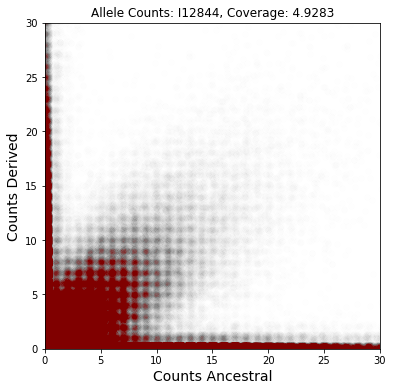

CPU times: user 9.15 s, sys: 173 ms, total: 9.32 s
Wall time: 15.8 s


In [19]:
%%time
plot_read_counts(sample="I12844")

# Check allele frequency LCT

In [53]:
ch = 2
position = 136608646

In [57]:
idx = (f["variants/CHROM"][:] == f"{ch}") & (f["variants/POS"][:]==position)
np.sum(idx) ### Print how many SNPs we found

1

In [91]:
%%time
gt_lct = f["calldata/GT"][idx,:,:]
gt2_lct = np.sum(gt_lct, axis=2)[0]
iid_lct = np.where(gt2_lct>0)[0]
print(f"Loaded Genotypes for MCM6 LCT variant for {len(gt_lct)} Samples")

Loaded Genotypes for MCM6 LCT variant for 1 Samples
CPU times: user 1.19 s, sys: 21.5 ms, total: 1.21 s
Wall time: 1.2 s


### 1 Second loading time. Not too bad!

In [82]:
print(f"Average Allele Frequency MCM6 in sample: {np.mean(gt_lct):.5f}")

Average Allele Frequency MCM6 in sample: 0.10380


In [95]:
print(f"Found n={len(iid_lct)} Individuals with LCT allele")

Found n=2498 Individuals with LCT allele


In [97]:
samples_lct = f["samples"][iid_lct]

In [98]:
samples_lct

array(['I1135', 'I1416', 'I2838', ..., 'LAV011', 'I14740.SG', 'I16232.SG'],
      dtype=object)